In [2]:
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms
# метрика качества 
from sklearn.metrics import accuracy_score

In [5]:
train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="./data", train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle = False)

In [8]:
dataiter = iter(train_loader)
# батч картинок и батч ответов к картинкам
images, labels = dataiter.next()

In [9]:
images.shape, labels.shape

(torch.Size([16, 3, 32, 32]), torch.Size([16]))

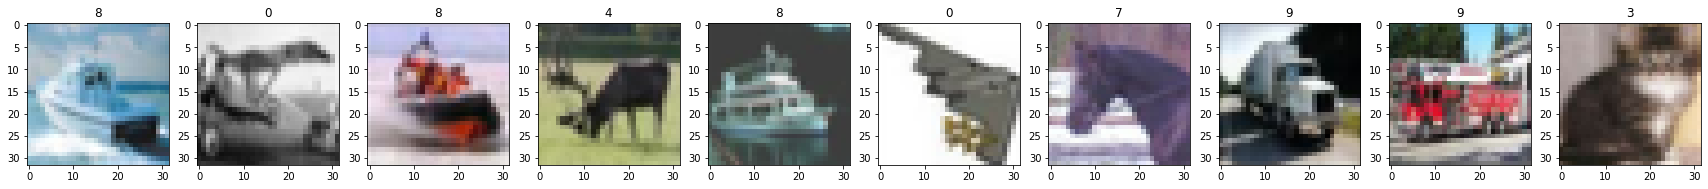

In [10]:
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
      axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
      axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)


In [11]:
num_to_name = {
    0: "Самолет",
    1: "Автомобиль",
    2: "Птица",
    3: "Кошка",
    4: "Олень",
    5: "Собака",
    6: "Лягушка",
    7: "Лошадь",
    8: "Корабль",
    9: "Грузовик"
}

In [13]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активайии для слоев нейронных сетей
import torch.nn.functional as F

In [14]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [15]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        self.fc1 = nn.Linear(32*32*3, 256)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.fc1(x))
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = F.softmax(self.fc2(x))
        return x

In [16]:
def train(net, n_epoch=2):
  # выбираем функцию потерь
  loss_fn = torch.nn.CrossEntropyLoss()

  # выбираем алгоритм оптимизации и learning_rate
  learning_rate = 1e-3
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  # обучаем сеть 2 эпохи
  for epoch in tqdm_notebook(range(n_epoch)):

      running_loss = 0.0
      train_dataiter = iter(train_loader)
      for i, batch in enumerate(tqdm_notebook(train_dataiter)):
          # так получаем текущий батч
          X_batch, y_batch = batch
          
          # обнуляем веса
          optimizer.zero_grad()

          # forward pass (получение ответов на батч картинок)
          y_pred = net(X_batch)
          # вычисление лосса от выданных сетью ответов и правильных ответов на батч
          loss = loss_fn(y_pred, y_batch)
          # bsckpropagation (вычисление градиентов)
          loss.backward()
          # обновление весов сети
          optimizer.step()

          # выведем текущий loss
          running_loss += loss.item()
          # выведем качество каждые 500 батчей
          if i % 500 == 499:
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 500))
              running_loss = 0.0

  print('Обучение закончено')
  return net

In [17]:
# объявляем сеть
net = SimpleNet()
# теперь обучить сеть можно вызвав функцию train и передав туда переменную сети.
net = train(net)

<ipython-input-16-f3beacc81db1>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epoch)):


  0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-16-f3beacc81db1>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataiter)):


  0%|          | 0/3125 [00:00<?, ?it/s]

<ipython-input-15-e2e35f115737>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


[1,   500] loss: 2.316
[1,  1000] loss: 2.205
[1,  1500] loss: 2.159
[1,  2000] loss: 2.143
[1,  2500] loss: 2.130
[1,  3000] loss: 2.135


  0%|          | 0/3125 [00:00<?, ?it/s]

[2,   500] loss: 2.115
[2,  1000] loss: 2.115
[2,  1500] loss: 2.101
[2,  2000] loss: 2.106
[2,  2500] loss: 2.095
[2,  3000] loss: 2.099
Обучение закончено


In [21]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [22]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))

<ipython-input-15-e2e35f115737>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


0.3683

In [23]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3)
        self.conv2 = nn.Conv2d(20, 3, kernel_size=3) 
        self.flatten = Flatten()
        self.fc = nn.Linear(2352, 10)
    
    def forward(self, x):
        # forward pass сети
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = F.softmax(self.fc(x))
        # print(x.shape)
        return x

In [24]:
net = ConvNet()

In [25]:
net = train(net)

<ipython-input-16-f3beacc81db1>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epoch)):


  0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-16-f3beacc81db1>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataiter)):


  0%|          | 0/3125 [00:00<?, ?it/s]

<ipython-input-23-1958dc8b3fef>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc(x))


[1,   500] loss: 2.210
[1,  1000] loss: 2.139
[1,  1500] loss: 2.132
[1,  2000] loss: 2.113
[1,  2500] loss: 2.101
[1,  3000] loss: 2.092


  0%|          | 0/3125 [00:00<?, ?it/s]

[2,   500] loss: 2.083
[2,  1000] loss: 2.083
[2,  1500] loss: 2.076
[2,  2000] loss: 2.087
[2,  2500] loss: 2.086
[2,  3000] loss: 2.082
Обучение закончено


In [26]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [ ]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))